In [1]:
'''
Following 4 cells are used for extracting features from the documents
Some parts are taken from problem set 1 solution, because it is faster
than my implementation in problem set 1 which took 5 hours for 1000 
documents.

'''

NUM_CASES = 1000

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from zipfile import ZipFile

cnt = 1
last_action = ""
def counter_message(max_cnt, action):
    """Displays Progress
    """
    global cnt, last_action
    
    #Reset Counter for every new action
    if last_action != action:
        cnt = 1
        last_action = action
    
    #Print Message
    print("\r{}/{}: {}.".format(cnt, max_cnt, action), end=" "*10, flush=True)
    cnt += 1

zfile = ZipFile("data/cases.zip")
caseids = []
raw_texts = {}
years = {}


# Randomly shuffle files and choose as many as we need
members = zfile.namelist()
if NUM_CASES is None:
    NUM_CASES = len(members)

# Reading csv
import pandas as pd
 
cases_ = pd.read_csv('case_metadata.csv')
cases_ = cases_.dropna(axis=0, how='any')
cases_ = cases_.reset_index()
cases_.head()

cases_values = np.random.permutation(cases_.values)[:NUM_CASES]

cases_dict = {}

for v in cases_values:
    cases_dict[v[1]] = [v[2],v[3],v[4],v[5]]


for case in members:
    year, caseid = case[:-4].split("_")
    if not (caseid in cases_dict.keys()):
        continue
    with zfile.open(case) as f:
        raw_text = f.read().decode()
    raw_texts[caseid] = raw_text
    years[caseid] = int(year)
    caseids.append(caseid)
    counter_message(NUM_CASES, "opened")

1000/1000: opened.                                                                                                             

In [2]:
import spacy
nlp = spacy.load('en') # requires:python -m spacy download en

spacy_documents = {}
for caseid in caseids:
    spacy_documents[caseid] = nlp(raw_texts[caseid])
    counter_message(NUM_CASES, "converted")

818/1000: converted.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

1000/1000: converted.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [3]:
from nltk import ngrams
import string

def normalize(token):
    """Normalize Token. Get Lemma (base form) and remove any punctuation
    """
    lemma = token.lemma_
    nopunct = lemma.translate(str.maketrans('', '', string.punctuation))
    return nopunct

noun_ngrams = {}
total_ngrams = []
word_counts= {}

# Lemmatize Cases
for caseid in caseids:
    tokens = []
    spacy_document = spacy_documents[caseid]
    for token in spacy_document:
        
        if not token.is_punct and not token.is_space: # Ignore spaces (newlines etc) and punctuation
            tokens.append(token)
            norm = normalize(token)
            
            if not norm in word_counts: # We've seen the word for the first time
                word_counts[norm] = 1
            else:                       # We already know this word
                word_counts[norm] += 1

    noun_ngram = []
    for ngram in ngrams(tokens, 3): # iterate over all 3-grams
        if ngram[2].pos_ == "NOUN": # check if last word is a noun
            curr_ngram = (normalize(ngram[0]),
                               normalize(ngram[1]),
                               normalize(ngram[2]))
            noun_ngram.append(curr_ngram)   # Stores 3-grams for this case
            total_ngrams.append(curr_ngram) # Stores 3-grams for all cases
    
    noun_ngrams[caseid] = noun_ngram
    counter_message(NUM_CASES, "lemmatized")

818/1000: lemmatized.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

1000/1000: lemmatized.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [4]:
pd.to_pickle(list(word_counts.keys()),'words.pkl')

In [5]:
from collections import Counter

X = []
y = []
cases_keys = []

N_features = 5000

# Get most common n_grams
most_common = Counter(total_ngrams).most_common(N_features)

for caseid in caseids:
    current_ngram = Counter(noun_ngrams[caseid])
    features = np.zeros(len(most_common))
    for i in range(len(most_common)):
        ngram = most_common[i][0]
        if ngram in current_ngram: #Only add most common 3-gram frequencies
            features[i] = current_ngram[ngram]
    X.append(features)
    y.append(cases_dict[caseid])
    cases_keys.append(caseid)
    counter_message(NUM_CASES, "created ML features")

# convert to numpy array
X = np.array(X)
y = np.array(y)

pd.to_pickle(X,'x_d_1000_f_5k.pkl')
pd.to_pickle(y,'y_d_1000_f_5k.pkl')
pd.to_pickle(y,'keys_d_1000_f_5k.pkl')

817/1000: created ML features.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

1000/1000: created ML features.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

"pd.to_pickle(X,'x_d_1000_f_5k.pkl')\npd.to_pickle(y,'y_d_1000_f_5k.pkl')\npd.to_pickle(y,'keys_d_1000_f_5k.pkl')"

Best model parameters {'C': 1.0, 'penalty': 'l2'}
Best model score 0.56875
Accuracy, train set: 1.0
Accuracy, test set: 0.53
F1 score, train set: 1.0
F1 score, test set: 0.626984126984127
[[125 255]
 [179 441]]


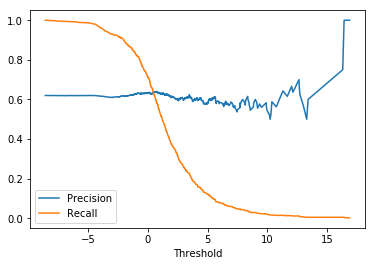

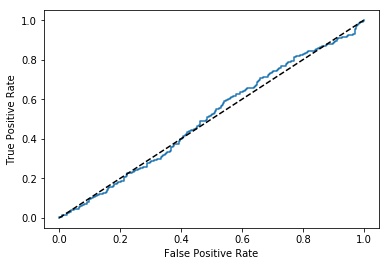

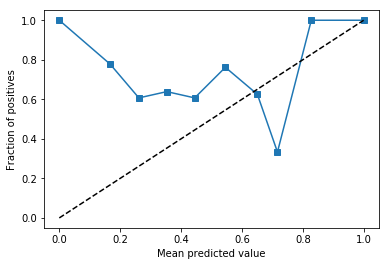

In [59]:
import numpy as np
import pandas as pd
# Loading dataset   
x_input = pd.read_pickle('x_d_1000_f_5k.pkl')   
y_output = pd.read_pickle('y_d_1000_f_5k.pkl')[:,0] 
    
# Scaling with Sparsity
from sklearn.preprocessing import StandardScaler
sparse_scaler = StandardScaler(with_mean=False)
x_input = sparse_scaler.fit_transform(x_input)
    
# Spliting data into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.2)

# Searching for best model parameters and score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
param_grid = {'C': np.logspace(0, 4, 10), 'penalty': ['l1', 'l2']}
clf_gs = GridSearchCV(lr, param_grid, cv=5, verbose=0)
best_model = clf_gs.fit(x_train, y_train)

print("Best model parameters " + str(clf_gs.best_params_))
print("Best model score " + str(clf_gs.best_score_))

# Logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=clf_gs.best_params_['C'], penalty=clf_gs.best_params_['penalty']).fit(x_train, y_train)

# Accuracy
print("Accuracy, train set: " + str(clf.score(x_train, y_train)))
print("Accuracy, test set: " + str(clf.score(x_test, y_test)))

# F1 score
from sklearn.metrics import f1_score
print("F1 score, train set: " + str(f1_score(y_train, clf.predict(x_train))))
print("F1 score, test set: " + str(f1_score(y_test, clf.predict(x_test))))

# Cross validation
from sklearn.model_selection import cross_val_predict

y_predicted = cross_val_predict(clf, x_input, y_output, cv=3)

from sklearn.metrics import confusion_matrix
conf_m = confusion_matrix(y_output, y_predicted)
print(conf_m)

# Precision recall curve
y_scores = cross_val_predict(clf, x_input, y_output, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_output, y_scores)

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()
plt.show()

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_output, y_scores)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Calibration plot 
from sklearn.calibration import calibration_curve

prob_pos = clf.decision_function(x_test)
prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.show()

[2.0, 0.0]
Accuracy, train set: 0.8927399514470973
Accuracy, test set: 0.19312641600953395
4946 non-zero of 5000 coefficients.


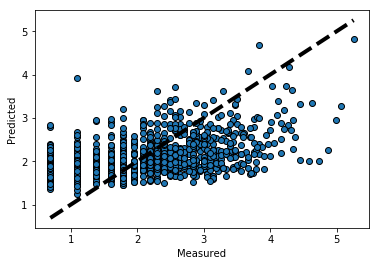

In [110]:
import numpy as np
import pandas as pd
# Loading dataset   
x_input = pd.read_pickle('x_d_1000_f_5k.pkl')   
y_output = pd.read_pickle('y_d_1000_f_5k.pkl')[:,3]   

# Scaling with Sparsity
from sklearn.preprocessing import StandardScaler
sparse_scaler = StandardScaler(with_mean=False)
x_input = sparse_scaler.fit_transform(x_input)    
    
# Spliting data into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.2)


from multiprocessing import cpu_count
nthreads = cpu_count() - 1
from sklearn.linear_model import ElasticNetCV
enet_reg = ElasticNetCV(alphas=[0.01,0.1,1.0,2.0,5.0,10.0], 
                        l1_ratio=[0.0,0.01,0.1,0.5,0.9,0.99,1.0],
                        max_iter=10000, n_jobs=nthreads)
enet_reg.fit(x_input, y_output)
print([enet_reg.alpha_, enet_reg.l1_ratio_])
#[1,0.01] best[0.1 0.01]


from sklearn.linear_model import ElasticNet
el_net = ElasticNet(alpha=enet_reg.alpha_, l1_ratio=enet_reg.l1_ratio_, max_iter=10000)
el_net.fit(x_train, y_train)

# Accuracy
print("Accuracy, train set: " + str(el_net.score(x_train, y_train)))
print("Accuracy, test set: " + str(el_net.score(x_test, y_test)))

nonzero = el_net.coef_ != 0
print(nonzero.sum(),'non-zero of',len(el_net.coef_),'coefficients.')
x_enet = np.array(x_input)[:,np.array(nonzero)]

# Cross validation
from multiprocessing import cpu_count
nthreads = cpu_count() - 1
from sklearn.model_selection import cross_val_predict
y_predicted = cross_val_predict(el_net, x_input, y_output,cv=3, n_jobs=nthreads)
#y_predicted = el_net.predict(x_input)

y_min = np.amin(y_output)
y_max = np.amax(y_output)

fig, ax = plt.subplots()
ax.scatter(y_output, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [3]:
# Adding average citation to each judge

import pandas as pd
cases = pd.read_csv('case_metadata.csv')
cases = cases.dropna(axis=0, how='any')
cases = cases.reset_index()

judges = {}

for k in range(len(cases['judge_id'])):
    judge = int(cases['judge_id'][k])
    if judge in judges.keys():
        judges[judge][0] = judges[judge][0] + np.exp(cases['log_cites'][k])
        judges[judge][1] = judges[judge][1] + 1
    else:
        judges[judge] = [np.exp(cases['log_cites'][k]),1]
        
for k,v in judges.items():
    judges[k][0] = np.log(judges[k][0] / judges[k][1])

judge_cites = np.zeros(len(cases['log_cites']))

for k in range(len(cases['judge_id'])):
    judge = int(cases['judge_id'][k])
    judge_cites[k] = judges[judge][0]
    
cases['log_judge_cites'] = judge_cites

print(cases.head())


   index  caseid  case_reversed  judge_id    year  log_cites  log_judge_cites
0      0  X3JGGO              0    1653.0  1925.0   1.098612         0.916291
1      1  X3OH3J              0    1034.0  1924.0   1.609438         1.897120
2      2  X3U0KO              0    2303.0  1925.0   1.791759         2.178532
3      7  X3JGJV              0     485.0  1925.0   2.708050         1.824549
4      8  X2S1PK              0    1113.0  1924.0   1.386294         1.098612


In [4]:
# 2SLS

from linearmodels.iv import IV2SLS

'''
X - citation of the case
Y - case reversed
Z - judge average citation
'''

formula_iv = 'case_reversed ~ 1  + C(year) + [log_cites ~ log_judge_cites]'
iv = IV2SLS.from_formula(formula_iv, data=cases)
results_iv = iv.fit(cov_type='clustered',clusters=cases['year'])
results_iv

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          case_reversed   R-squared:                      0.0551
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0354
No. Observations:                4399   F-statistic:                -5.156e+21
Date:                Wed, Apr 17 2019   P-value (F-stat)                1.0000
Time:                        13:02:09   Distribution:                 chi2(90)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             0.5444     0.0381     14.296     0.0000      0.4698      0.6190
C(year)[T.1925.0]     0.1777     0.0062     28.591     0.0000      0.1655      0.1899
C(year)[T.1926.0]     0.1642     0.0080     20.650     0.0000      0.1487      0.1798
C(year)[T.1927.0]     0.4154     0.0037     112.53     0.0000      0.4082      0.4227
C(year)[T.1928.0]     0.2698     0.0085     31.873     0.0000      0.2532      0.2863
C(year)[T.1929.0]     0.0523     0.0098     5.3329     0.0000      0.0331      0.0715
C(year)[T.1930.0]     0.1280     0.0005     241.94     0.0000      0.1270      0.1291
C(year)[T.1931.0]    -0.0074     0.0056    -1.3150     0.1885     -0.0184      0.0036
C(year)[T.1932.0]    -0.0168     0.0030    -5.5430     0.0000     -0.0228     -0.0109
C(year)[T.1933.0]     0.1613     0.0100     16.162     0.0000      0.1418      0.1809
C(year)[T.1934.0]     0.0850     0.0013     65.723     0.0000      0.0825      0.0876
C(year)[T.1935.0]    -0.0633     0.0049    -12.857     0.0000     -0.0730     -0.0537
C(year)[T.1936.0]     0.1189     0.0049     24.482     0.0000      0.1094      0.1284
C(year)[T.1937.0]     0.2766     0.0054     50.976     0.0000      0.2660      0.2872
C(year)[T.1938.0]    -0.0039     0.0072    -0.5406     0.5888     -0.0181      0.0103
C(year)[T.1939.0]     0.2416     0.0026     93.003     0.0000      0.2365      0.2466
C(year)[T.1940.0]     0.2277     0.0002     1241.0     0.0000      0.2273      0.2280
C(year)[T.1941.0]     0.2969     0.0018     167.93     0.0000      0.2934      0.3003
C(year)[T.1942.0]     0.1972     0.0016     124.18     0.0000      0.1941      0.2003
C(year)[T.1943.0]     0.1843     0.0031     59.272     0.0000      0.1782      0.1904
C(year)[T.1944.0]     0.2042     0.0002     1263.8     0.0000      0.2039      0.2045
C(year)[T.1945.0]     0.2173     0.0014     160.76     0.0000      0.2147      0.2200
C(year)[T.1946.0]     0.1303  3.349e-05     3890.3     0.0000      0.1302      0.1303
C(year)[T.1947.0]     0.2818     0.0024     116.62     0.0000      0.2771      0.2866
C(year)[T.1948.0]     0.2561     0.0017     150.61     0.0000      0.2528      0.2594
C(year)[T.1949.0]     0.2863     0.0066     43.690     0.0000      0.2735      0.2992
C(year)[T.1950.0]     0.3169     0.0060     52.957     0.0000      0.3051      0.3286
C(year)[T.1951.0]     0.1291     0.0054     23.836     0.0000      0.1185      0.1397
C(year)[T.1952.0]     0.2609     0.0020     132.44     0.0000      0.2571      0.2648
C(year)[T.1953.0]     0.2464     0.0191     12.880     0.0000      0.2089      0.2839
C(year)[T.1954.0]     0.3488     0.0133     26.313     0.0000      0.3229      0.3748
C(year)[T.1955.0]     0.2712   7.44e-05     3645.9     0.0000      0.2711      0.2714
C(year)[T.1956.0]     0.2406     0.0030     79.412     0.0000      0.2347      0.2465
C(year)[T.1957.0]     0.2478     0.0050     49.140     0.0000      0.2379      0.2577
C(year)[T.1958.0]     0.3104     0.0019     166

In [5]:
# OLS
formula_ols = 'case_reversed ~ 1 + C(year) + log_cites'
ols = IV2SLS.from_formula(formula_ols, data=cases)
results_ols = ols.fit(cov_type='clustered',clusters=cases['year'])
results_ols

OLS Estimation Summary                            
==============================================================================
Dep. Variable:          case_reversed   R-squared:                      0.0623
Estimator:                        OLS   Adj. R-squared:                 0.0427
No. Observations:                4399   F-statistic:                -7.091e+22
Date:                Wed, Apr 17 2019   P-value (F-stat)                1.0000
Time:                        13:02:12   Distribution:                 chi2(90)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             0.4616     0.0166     27.825     0.0000      0.4291      0.4941
C(year)[T.1925.0]     0.1912     0.0027     70.626     0.0000      0.1859      0.1965
C(year)[T.1926.0]     0.1815     0.0035     52.398     0.0000      0.1748      0.1883
C(year)[T.1927.0]     0.4235     0.0016     263.32     0.0000      0.4203      0.4266
C(year)[T.1928.0]     0.2882     0.0037     78.161     0.0000      0.2809      0.2954
C(year)[T.1929.0]     0.0736     0.0043     17.236     0.0000      0.0653      0.0820
C(year)[T.1930.0]     0.1292     0.0002     560.39     0.0000      0.1287      0.1296
C(year)[T.1931.0]     0.0048     0.0025     1.9749     0.0483   3.655e-05      0.0097
C(year)[T.1932.0]    -0.0102     0.0013    -7.7308     0.0000     -0.0128     -0.0076
C(year)[T.1933.0]     0.1830     0.0043     42.095     0.0000      0.1745      0.1916
C(year)[T.1934.0]     0.0878     0.0006     155.87     0.0000      0.0867      0.0889
C(year)[T.1935.0]    -0.0526     0.0021    -24.521     0.0000     -0.0568     -0.0484
C(year)[T.1936.0]     0.1295     0.0021     61.193     0.0000      0.1253      0.1336
C(year)[T.1937.0]     0.2884     0.0024     122.01     0.0000      0.2838      0.2930
C(year)[T.1938.0]     0.0118     0.0032     3.7526     0.0002      0.0057      0.0180
C(year)[T.1939.0]     0.2472     0.0011     218.49     0.0000      0.2450      0.2494
C(year)[T.1940.0]     0.2273  7.992e-05     2843.7     0.0000      0.2271      0.2274
C(year)[T.1941.0]     0.3007     0.0008     390.48     0.0000      0.2992      0.3022
C(year)[T.1942.0]     0.1938     0.0007     280.08     0.0000      0.1924      0.1951
C(year)[T.1943.0]     0.1911     0.0014     141.06     0.0000      0.1884      0.1937
C(year)[T.1944.0]     0.2046  7.039e-05     2906.2     0.0000      0.2044      0.2047
C(year)[T.1945.0]     0.2203     0.0006     374.02     0.0000      0.2191      0.2214
C(year)[T.1946.0]     0.1302  1.459e-05     8925.5     0.0000      0.1302      0.1302
C(year)[T.1947.0]     0.2871     0.0011     272.70     0.0000      0.2850      0.2892
C(year)[T.1948.0]     0.2524     0.0007     340.75     0.0000      0.2509      0.2538
C(year)[T.1949.0]     0.2721     0.0029     95.300     0.0000      0.2665      0.2777
C(year)[T.1950.0]     0.3038     0.0026     116.57     0.0000      0.2987      0.3089
C(year)[T.1951.0]     0.1173     0.0024     49.725     0.0000      0.1127      0.1220
C(year)[T.1952.0]     0.2566     0.0009     299.04     0.0000      0.2550      0.2583
C(year)[T.1953.0]     0.2048     0.0083     24.573     0.0000      0.1884      0.2211
C(year)[T.1954.0]     0.3200     0.0058     55.411     0.0000      0.3087      0.3313
C(year)[T.1955.0]     0.2711  3.241e-05     8364.4     0.0000      0.2710      0.2711
C(year)[T.1956.0]     0.2340     0.0013     177.30     0.0000      0.2314      0.2366
C(year)[T.1957.0]     0.2368     0.0022     107.81     0.0000      0.2325      0.2411
C(year)[T.1958.0]     0.3063     0.0008     376.5

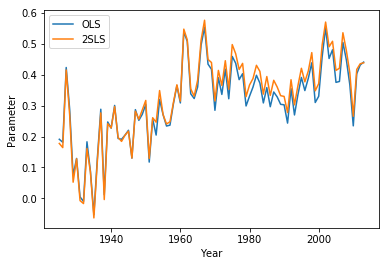

In [7]:
# Comparing 2SLS and OLS
plt.plot(range(1925,2014),results_ols.params[1:90],label="OLS")
plt.plot(range(1925,2014),results_iv.params[1:90],label="2SLS")
plt.xlabel('Year')
plt.ylabel('Parameter')
plt.legend()
plt.show()
# 2SLS estimates are slightly higher than OLS estimates from 1970

In [17]:
# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary()

# Reading documents
from glob import glob
import spacy
import numpy as np

N_files = 100

fnames = np.random.permutation(glob('cases/*txt'))[:N_files]

nlp = spacy.load('en')

iteration = 1

cases_text = []

stopwords = spacy.lang.en.stop_words.STOP_WORDS

for fname in fnames:
    docid = fname.split('\\')[-1][5:-4] # cut filepath and extension
    year = fname.split('\\')[-1][:4]
    if iteration % (N_files//10) == 0:
        print(str(100*iteration/N_files) + "%")
    iteration = iteration + 1
    text = open(fname,'r', encoding='utf8').read() # read file as string
    doc=nlp(text)
    document = []
    for sent in doc.sents:
        for token in sent:
            # remove spaces, punctuation, stopwords and digits
            if not(token.is_space) and not(token.is_punct) and not(token.lower_ in stopwords) and not(token.is_digit): 
                document.append(token.lemma_)  
    #print(document)
    cases_text.append(document)
    dictionary.add_documents([document])


10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [26]:
# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in cases_text]

from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

[(0,
  [('court', 0.016090002),
   ("'s", 0.015633825),
   ('state', 0.014059034),
   ('s.ct', 0.012065789),
   ('u.s.', 0.010539373),
   ('v.', 0.009156146),
   ('act', 0.0073218667),
   ('district', 0.0064004995),
   ('federal', 0.006242837),
   ('vopa', 0.005733218)]),
 (1,
  [('court', 0.015279445),
   ("'s", 0.013028604),
   ('corporation', 0.009066083),
   ('case', 0.008068815),
   ('appellant', 0.007311903),
   ('return', 0.0067396904),
   ('district', 0.006507768),
   ('law', 0.0064994404),
   ('v.', 0.0062842327),
   ('subsidiary', 0.005410548)]),
 (2,
  [("'s", 0.00933429),
   ('stop', 0.008507688),
   ('stoddard', 0.008431564),
   ('v.', 0.00819964),
   ('court', 0.0070406497),
   ('f.3d', 0.0068715215),
   ('suspicion', 0.0068688425),
   ('reasonable', 0.0068458337),
   ('arvizu', 0.006193718),
   ('officer', 0.0052391393)]),
 (3,
  [('court', 0.014737164),
   ('v.', 0.010685124),
   ("'s", 0.009786714),
   ('case', 0.0065043406),
   ('service', 0.0060367184),
   ('district

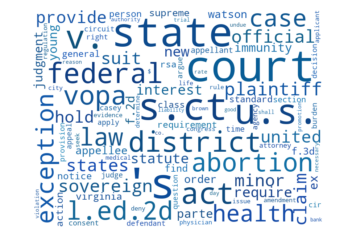

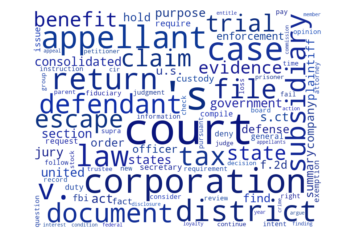

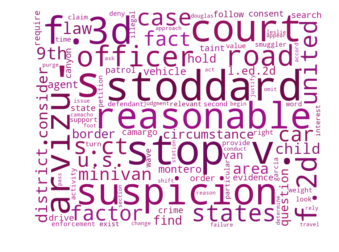

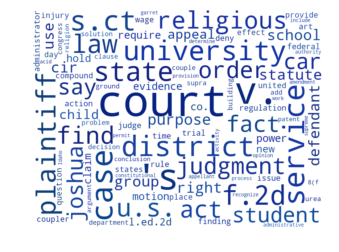

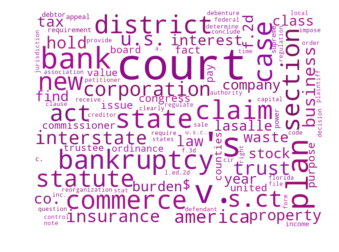

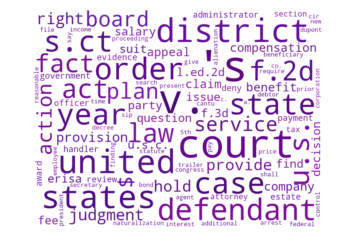

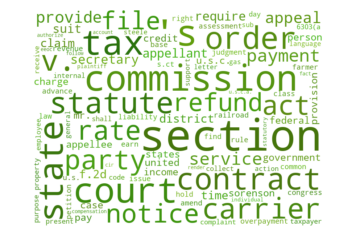

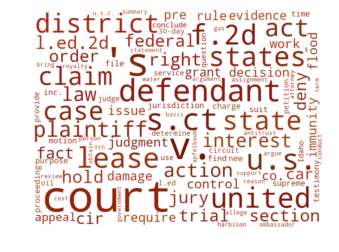

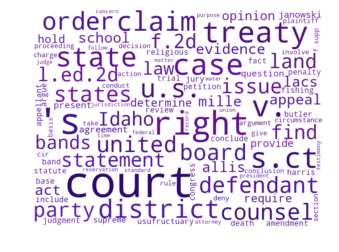

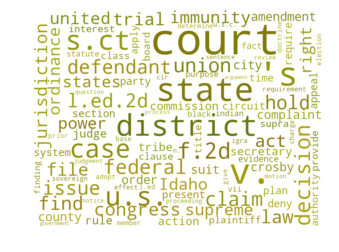

In [62]:
from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i,weights in lda.show_topics(num_topics=-1, num_words=100, formatted=False):
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [55]:
N_features = 5000

import numpy as np
import pandas as pd

# Loading dataset   
x_input = pd.read_pickle('x_d_1000_f_5k.pkl')   
y_output = pd.read_pickle('y_d_1000_f_5k.pkl')[:,0] 

y_output = np.reshape(y_output,(1000,1))

# Scaling with Sparsity
from sklearn.preprocessing import StandardScaler
sparse_scaler = StandardScaler(with_mean=False)
x_input = sparse_scaler.fit_transform(x_input)
    
# Spliting data into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.2)

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

model = Sequential()
model.add(Dense(units=1,  # output dim is 2, one score per each class
                activation='sigmoid',
                kernel_regularizer=L1L2(l1=0.0, l2=2.0),
                input_dim=N_features))  # input dimension = number of features your data has
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
          
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), verbose=2)

scores = model.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# It has almost the same accuracy as the sklearn logistic regretion 

Train on 800 samples, validate on 200 samples
Epoch 1/100
 - 1s - loss: 2.6796 - acc: 0.5637 - val_loss: 1.2993 - val_acc: 0.6150
Epoch 2/100
 - 0s - loss: 0.8383 - acc: 0.7662 - val_loss: 0.7956 - val_acc: 0.6050
Epoch 3/100
 - 0s - loss: 0.6368 - acc: 0.8113 - val_loss: 0.7788 - val_acc: 0.5800
Epoch 4/100
 - 0s - loss: 0.6215 - acc: 0.8025 - val_loss: 0.7712 - val_acc: 0.5900
Epoch 5/100
 - 0s - loss: 0.6209 - acc: 0.8438 - val_loss: 0.7733 - val_acc: 0.5950
Epoch 6/100
 - 0s - loss: 0.6261 - acc: 0.8350 - val_loss: 0.7736 - val_acc: 0.6200
Epoch 7/100
 - 0s - loss: 0.6231 - acc: 0.8100 - val_loss: 0.7760 - val_acc: 0.5750
Epoch 8/100
 - 0s - loss: 0.6264 - acc: 0.8313 - val_loss: 0.7825 - val_acc: 0.6200
Epoch 9/100
 - 0s - loss: 0.6263 - acc: 0.8250 - val_loss: 0.7719 - val_acc: 0.6250
Epoch 10/100
 - 0s - loss: 0.6350 - acc: 0.8062 - val_loss: 0.7803 - val_acc: 0.5900
Epoch 11/100
 - 0s - loss: 0.6344 - acc: 0.8163 - val_loss: 0.7770 - val_acc: 0.5950
Epoch 12/100
 - 0s - loss: 0

Epoch 97/100
 - 0s - loss: 0.6370 - acc: 0.7437 - val_loss: 0.7796 - val_acc: 0.6100
Epoch 98/100
 - 0s - loss: 0.6284 - acc: 0.7312 - val_loss: 0.7828 - val_acc: 0.5900
Epoch 99/100
 - 0s - loss: 0.6288 - acc: 0.7762 - val_loss: 0.7762 - val_acc: 0.6150
Epoch 100/100
 - 0s - loss: 0.6291 - acc: 0.7750 - val_loss: 0.7759 - val_acc: 0.6000
200/200 [==============================] - ETA:  - 0s 105us/step

acc: 60.00%


In [63]:
from keras.layers import Dropout

x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.2)

model_h = Sequential()
model_h.add(Dense(units=512, activation='relu', kernel_regularizer=L1L2(l1=0.0, l2=2.0)))
model_h.add(Dropout(0.2))
model_h.add(Dense(units=256, activation='relu',kernel_regularizer=L1L2(l1=0.0, l2=2.0)))
model_h.add(Dropout(0.2))
model_h.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(l1=0.0, l2=2.0)))
model_h.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
          
model_h.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=2)

scores = model_h.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model_h.metrics_names[1], scores[1]*100))


Train on 800 samples, validate on 200 samples
Epoch 1/100
 - 4s - loss: 1134.8620 - acc: 0.4575 - val_loss: 336.1035 - val_acc: 0.6350
Epoch 2/100
 - 2s - loss: 185.6328 - acc: 0.6175 - val_loss: 93.2639 - val_acc: 0.6650
Epoch 3/100
 - 2s - loss: 54.0445 - acc: 0.6088 - val_loss: 25.1696 - val_acc: 0.6650
Epoch 4/100
 - 2s - loss: 14.1890 - acc: 0.6088 - val_loss: 6.5072 - val_acc: 0.6650
Epoch 5/100
 - 2s - loss: 3.7561 - acc: 0.6088 - val_loss: 1.9139 - val_acc: 0.6650
Epoch 6/100
 - 2s - loss: 1.3313 - acc: 0.6088 - val_loss: 0.9441 - val_acc: 0.6650
Epoch 7/100
 - 2s - loss: 0.8345 - acc: 0.6088 - val_loss: 0.7500 - val_acc: 0.6650
Epoch 8/100
 - 2s - loss: 0.7304 - acc: 0.6088 - val_loss: 0.7021 - val_acc: 0.6650
Epoch 9/100
 - 2s - loss: 0.7006 - acc: 0.6088 - val_loss: 0.6847 - val_acc: 0.6650
Epoch 10/100
 - 2s - loss: 0.6887 - acc: 0.6088 - val_loss: 0.6762 - val_acc: 0.6650
Epoch 11/100
 - 2s - loss: 0.6829 - acc: 0.6088 - val_loss: 0.6716 - val_acc: 0.6650
Epoch 12/100
 - 2

Epoch 97/100
 - 2s - loss: 0.6694 - acc: 0.6088 - val_loss: 0.6446 - val_acc: 0.6650
Epoch 98/100
 - 2s - loss: 0.6694 - acc: 0.6088 - val_loss: 0.6445 - val_acc: 0.6650
Epoch 99/100
 - 2s - loss: 0.6694 - acc: 0.6088 - val_loss: 0.6446 - val_acc: 0.6650
Epoch 100/100
 - 2s - loss: 0.6694 - acc: 0.6088 - val_loss: 0.6447 - val_acc: 0.6650
200/200 [==============================] - ETA:  - ETA:  - 0s 603us/step

acc: 66.50%
